# SQL

In [1]:
"""
Here we will be creating an SQL database to store disease signatures from iLINCS!

We will filter those signatures which belong to diseases - which are >9,000 signatures
from the iLINCS database.

Resources: 
    * http://www.ilincs.org/ilincs/APIinfo
"""

'\nHere we will be creating an SQL database to store disease signatures from iLINCS!\n\nResources: \n    * http://www.ilincs.org/ilincs/APIinfo\n'

## Create Table Dataset

In [2]:
# 1. Imports, Variables, Functions
import psycopg2
import pandas as pd
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# SQL variables
dbname = "ilincs"
user = "ddalton"
password = "Teclado$$$111"
host = "localhost"
path_data = "../../data/iLINCS/datasets.csv"
path_signature = "../../data/iLINCS/signatures.csv"
table_name = "datasets"
primary_key = "experiment"
int_columns = ["nsamples"]  # INT columns - rest TEXT
drop_table = True


# functions
def get_disease_datasets():
    """
    Get Disease Datasets
    Function to retrieve from those filtered signatures the datasetid

    Arguments:

    Return:
    datasetid: list()
        List of unique dataset id's
    """
    path_data = "../../data/iLINCS/signatures.csv"
    filter_df = lambda df: df["libraryid"] == "LIB_1"

    # Load Data
    try:
        df_data = pd.read_csv(path_data)
        logging.info("Data loaded successfully.")
    except FileNotFoundError:
        logging.error("Data file not found. Please check the file path.")
        exit()

    # filter disease signatures
    df_data = df_data[filter_df]

    return list(df_data["datasetid"].unique())


# 2. Load Data
try:
    df_data = pd.read_csv(path_data)
    logging.info("Data loaded successfully.")
except FileNotFoundError:
    logging.error("Data file not found. Please check the file path.")
    exit()

# get unique disease dataset id's
unique_datasetid = get_disease_datasets()

# filter disease signatures
# dataset id's refer to experiment
df_data = df_data[df_data["experiment"].isin(unique_datasetid)]

# assert we find all dataset id's
assert len(unique_datasetid) == len(
    df_data["experiment"].unique()
), "Error, Dataset Table does not conain all unique datasetid"

# get max length for each
max_lengths = [
    max([len(str(n)) for n in df_data[c].to_list()]) for c in df_data.columns
]

# Convert specified integer columns and handle NaN by replacing with 0
for col in int_columns:
    df_data[col] = pd.to_numeric(df_data[col], errors="coerce").fillna(0).astype(int)

# For other columns, replace NaN with None (which will become NULL in SQL)
for col in df_data.columns:
    if col not in int_columns:
        df_data[col] = df_data[col].where(pd.notnull(df_data[col]), None)

# Drop Duplicate for experiment column
df_data = df_data.drop_duplicates(subset="experiment", keep="first")

logging.info(f"Shape of filtered DataFrame: {df_data.shape}")

2023-12-04 14:54:53,827 - INFO - Data loaded successfully.
/tmp/ipykernel_134319/2803087972.py:41: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(path_data)
2023-12-04 14:54:54,413 - INFO - Data loaded successfully.
2023-12-04 14:54:54,459 - INFO - Shape of filtered DataFrame: (1087, 16)


In [3]:
# 3. Connect with Database
try:
    conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host)
    logging.info("Connected to the database successfully.")
except psycopg2.OperationalError as e:
    logging.error(f"Unable to connect to the database: {e}")
    exit()

# 4. Create Cursor Object
cursor = conn.cursor()

# 5. Check if Table Exists and Delete Data if It Does
# Check if the table exists and drop it if it does
if drop_table:
    try:
        cursor.execute(f"DROP TABLE IF EXISTS {table_name};")
        conn.commit()
        print(f"Table {table_name} dropped successfully if it existed.")
    except psycopg2.Error as e:
        print(f"An error occurred: {e}")
        conn.rollback()


cursor.execute(
    "SELECT EXISTS(SELECT * FROM information_schema.tables WHERE table_name=%s)",
    (table_name,),
)
table_exists = cursor.fetchone()[0]

if table_exists:
    try:
        cursor.execute(f"DELETE FROM {table_name};")
        conn.commit()
        logging.info(f"Existing data in table {table_name} deleted successfully.")
    except psycopg2.Error as e:
        logging.error(f"An error occurred while deleting data from the table: {e}")
        cursor.close()
        conn.close()
        exit()
else:
    # Create table if it does not exist
    column_text = ", ".join(
        f"{c} VARCHAR({n + 10})" if c not in int_columns else f"{c} INT"
        for c, n in zip(df_data.columns, max_lengths)
    )
    create_table_query = (
        f"CREATE TABLE {table_name} ({column_text}, PRIMARY KEY({primary_key}));"
    )
    try:
        cursor.execute(create_table_query)
        conn.commit()
        logging.info(f"Table {table_name} created successfully.")
    except psycopg2.Error as e:
        logging.error(f"An error occurred while creating the table: {e}")
        cursor.close()
        conn.close()
        exit()

2023-12-04 14:55:12,807 - INFO - Connected to the database successfully.
2023-12-04 14:55:12,813 - INFO - Table datasets created successfully.


Table datasets dropped successfully if it existed.


In [4]:
# 6. Dump Data into Table
data_tuples = list(df_data.itertuples(index=False, name=None))
insert_query = (
    f"INSERT INTO {table_name} ({', '.join(df_data.columns)}) VALUES (%s"
    + ", %s" * (len(df_data.columns) - 1)
    + ")"
)

try:
    with conn:
        with conn.cursor() as curs:
            for record in data_tuples:
                try:
                    curs.execute(insert_query, record)
                except psycopg2.Error as e:
                    logging.error(f"Error inserting record {record}: {e}")
                    # Optionally, you can break the loop after logging the first error
                    break
    logging.info(f"Data dumped into {table_name} successfully.")
except psycopg2.Error as e:
    logging.error(f"An error occurred while inserting data into the table: {e}")
    conn.rollback()
    exit()

2023-12-04 14:55:17,467 - INFO - Data dumped into datasets successfully.


## Create Signature Table

In [1]:
# 1. Imports, Variables, Functions
import psycopg2
import pandas as pd
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# SQL variables
dbname = "ilincs"
user = "ddalton"
password = "Teclado$$$111"
host = "localhost"
path_data = "../../data/iLINCS/signatures.csv"
table_name = "signatures"
primary_key = "signatureid"
int_columns = ["nCtrSamples", "nTrtSamples", "pubChemID"]  # INT columns - rest TEXT
drop_table = True
filter_df = lambda df: df["libraryid"] == "LIB_1"
reference_table = "datasets"
reference_key = "experiment"
foreign_key = "datasetid"

# 2. Load Data
try:
    df_data = pd.read_csv(path_data)
    logging.info("Data loaded successfully.")
except FileNotFoundError:
    logging.error("Data file not found. Please check the file path.")
    exit()

# filter disease signatures
# which are libraryid LIB_1
df_data = df_data[filter_df]

# get max length for each
max_lengths = [
    max([len(str(n)) for n in df_data[c].to_list()]) for c in df_data.columns
]

# Convert specified integer columns and handle NaN by replacing with 0
for col in int_columns:
    df_data[col] = pd.to_numeric(df_data[col], errors="coerce").fillna(0).astype(int)

# For other columns, replace NaN with None (which will become NULL in SQL)
for col in df_data.columns:
    if col not in int_columns:
        df_data[col] = df_data[col].where(pd.notnull(df_data[col]), None)

logging.info(f"Shape of filtered DataFrame: {df_data.shape}")
# 3. Connect with Database
try:
    conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host)
    logging.info("Connected to the database successfully.")
except psycopg2.OperationalError as e:
    logging.error(f"Unable to connect to the database: {e}")
    exit()

# 4. Create Cursor Object
cursor = conn.cursor()

# 5. Check if Table Exists and Delete Data if It Does

# Check if the table exists and drop it if it does
if drop_table:
    try:
        cursor.execute(f"DROP TABLE IF EXISTS {table_name};")
        conn.commit()
        print(f"Table {table_name} dropped successfully if it existed.")
    except psycopg2.Error as e:
        print(f"An error occurred: {e}")
        conn.rollback()


cursor.execute(
    "SELECT EXISTS(SELECT * FROM information_schema.tables WHERE table_name=%s)",
    (table_name,),
)
table_exists = cursor.fetchone()[0]

if table_exists:
    try:
        cursor.execute(f"DELETE FROM {table_name};")
        conn.commit()
        logging.info(f"Existing data in table {table_name} deleted successfully.")
    except psycopg2.Error as e:
        logging.error(f"An error occurred while deleting data from the table: {e}")
        cursor.close()
        conn.close()
        exit()
else:
    # Create table if it does not exist
    column_text = ", ".join(
        f"{c} VARCHAR({n + 10})" if c not in int_columns else f"{c} INT"
        for c, n in zip(df_data.columns, max_lengths)
    )
    create_table_query = f"CREATE TABLE {table_name} ({column_text}, PRIMARY KEY({primary_key}),FOREIGN KEY ({foreign_key}) REFERENCES {reference_table}({reference_key}));"
    try:
        cursor.execute(create_table_query)
        conn.commit()
        logging.info(f"Table {table_name} created successfully.")
    except psycopg2.Error as e:
        logging.error(f"An error occurred while creating the table: {e}")
        cursor.close()
        conn.close()
        exit()

/tmp/ipykernel_135693/106177209.py:28: DtypeWarning: Columns (0,3,7,8,9,10,15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(path_data)
2023-12-04 14:59:17,169 - INFO - Data loaded successfully.
2023-12-04 14:59:17,234 - INFO - Shape of filtered DataFrame: (9097, 30)
2023-12-04 14:59:17,241 - INFO - Connected to the database successfully.
2023-12-04 14:59:17,248 - INFO - Table signatures created successfully.


Table signatures dropped successfully if it existed.


In [2]:
# 6. Dump Data into Table
data_tuples = list(df_data.itertuples(index=False, name=None))
insert_query = (
    f"INSERT INTO {table_name} ({', '.join(df_data.columns)}) VALUES (%s"
    + ", %s" * (len(df_data.columns) - 1)
    + ")"
)

try:
    with conn:
        with conn.cursor() as curs:
            for record in data_tuples:
                try:
                    curs.execute(insert_query, record)
                except psycopg2.Error as e:
                    logging.error(f"Error inserting record {record}: {e}")
                    # Optionally, you can break the loop after logging the first error
                    break
    logging.info(f"Data dumped into {table_name} successfully.")
except psycopg2.Error as e:
    logging.error(f"An error occurred while inserting data into the table: {e}")
    conn.rollback()
    exit()

2023-12-04 14:59:24,120 - INFO - Data dumped into signatures successfully.


## Create Table Genes

In [10]:
# 1. Imports, Variables, Functions
import psycopg2
import pandas as pd
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# SQL variables
dbname = "ilincs"
user = "ddalton"
password = "Teclado$$$111"
host = "localhost"
path_data = "../../data/iLINCS/genes.csv"
table_name = "genes"
primary_keys = []
int_columns = []  # INT columns - rest TEXT
drop_table = True
foreign_key = ""
parent_table = ""
parent_id = ""
# 2. Load Data
try:
    df_data = pd.read_csv(path_data)
    logging.info("Data loaded successfully.")
except FileNotFoundError:
    logging.error("Data file not found. Please check the file path.")
    exit()

2023-11-27 16:06:40,379 - INFO - Data loaded successfully.


In [11]:
df_data

,chromosome,dbxrefs,description,geneid,homologeneid,locustag,maplocation,namenomauth,nomstatus,symbol,symbonomauth,synonyms,taxid,typeofgene
0,19,MIM:138670|HGNC:HGNC:5|Ensembl:ENSG00000121410...,alpha-1-B glycoprotein,1,11167.0,-,19q13.4,alpha-1-B glycoprotein,O,A1BG,A1BG,A1B|ABG|GAB|HYST2477,9606,protein-coding
1,12,MIM:103950|HGNC:HGNC:7|Ensembl:ENSG00000175899...,alpha-2-macroglobulin,2,37248.0,-,12p13.31,alpha-2-macroglobulin,O,A2M,A2M,A2MD|CPAMD5|FWP007|S863-7,9606,protein-coding
2,12,HGNC:HGNC:8|Ensembl:ENSG00000256069,alpha-2-macroglobulin pseudogene 1,3,NaN,-,12p13.31,alpha-2-macroglobulin pseudogene 1,O,A2MP1,A2MP1,A2MP,9606,pseudo
3,11,HGNC:11|MIM:108985,"atrophia areata, peripapillary chorioretinal d...",8,NaN,-,11p15,"atrophia areata, peripapillary chorioretinal d...",0,AA,AA,-,9606,unknown
4,8,MIM:108345|HGNC:HGNC:7645|Ensembl:ENSG00000171...,N-acetyltransferase 1 (arylamine N-acetyltrans...,9,37329.0,-,8p22,N-acetyltransferase 1 (arylamine N-acetyltrans...,O,NAT1,NAT1,AAC1|MNAT|NAT-1|NATI,9606,protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235977,3,-,ribosomal protein S27a pseudogene,105650979,NaN,-,-,-,-,LOC105650979,-,-,10116,pseudo
235978,7,-,ribosomal protein S27a pseudogene,105650980,NaN,-,-,-,-,LOC105650980,-,-,10116,pseudo
235979,12,-,"NLR family, pyrin domain containing 5 pseudogene",105661729,NaN,-,-,-,-,LOC105661729,-,-,10090,pseudo
235980,1,-,long intergenic non-coding RNA muscle differen...,105661730,NaN,-,-,-,-,Linc-md1,-,-,10090,ncRNA


## Query

In [ ]:
# SQL variables
dbname = "ilincs"
user = "ddalton"
password = "Teclado$$$111"
host = "localhost"
table_name = "signatures"

# Connect to the database
try:
    conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host)
    print("Connected to the database successfully.")
except psycopg2.OperationalError as e:
    print(f"Unable to connect to the database: {e}")
    exit()

# Query the table
try:
    query = f"SELECT * FROM {table_name} LIMIT 10;"  # Adjust the query as needed
    query = f"SELECT * FROM {table_name} WHERE antibodytarget IS NOT NULL;"
    query = f"SELECT * FROM {table_name} WHERE experiment IS  NULL;"
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, conn)
    print(df)
except Exception as e:
    print(f"An error occurred while querying the table: {e}")
finally:
    conn.close()

# The DataFrame 'df' now contains the first 10 rows of the table.

Connected to the database successfully.
     antibodytarget cellline tissue       cid compound concentration  \
0              None     None   None     cID_1     None          None   
1              None     None   None    cID_10     None          None   
2              None     None   None   cID_100     None          None   
3              None     None   None  cID_1000     None          None   
4              None     None   None  cID_1001     None          None   
...             ...      ...    ...       ...      ...           ...   
9092           None     None   None   cID_995     None          None   
9093           None     None   None   cID_996     None          None   
9094           None     None   None   cID_997     None          None   
9095           None     None   None   cID_998     None          None   
9096           None     None   None   cID_999     None          None   

     concordancetable   datasetid     factor   level1  ... clueiocompound  \
0     concordanceL

/tmp/ipykernel_242232/3388944588.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


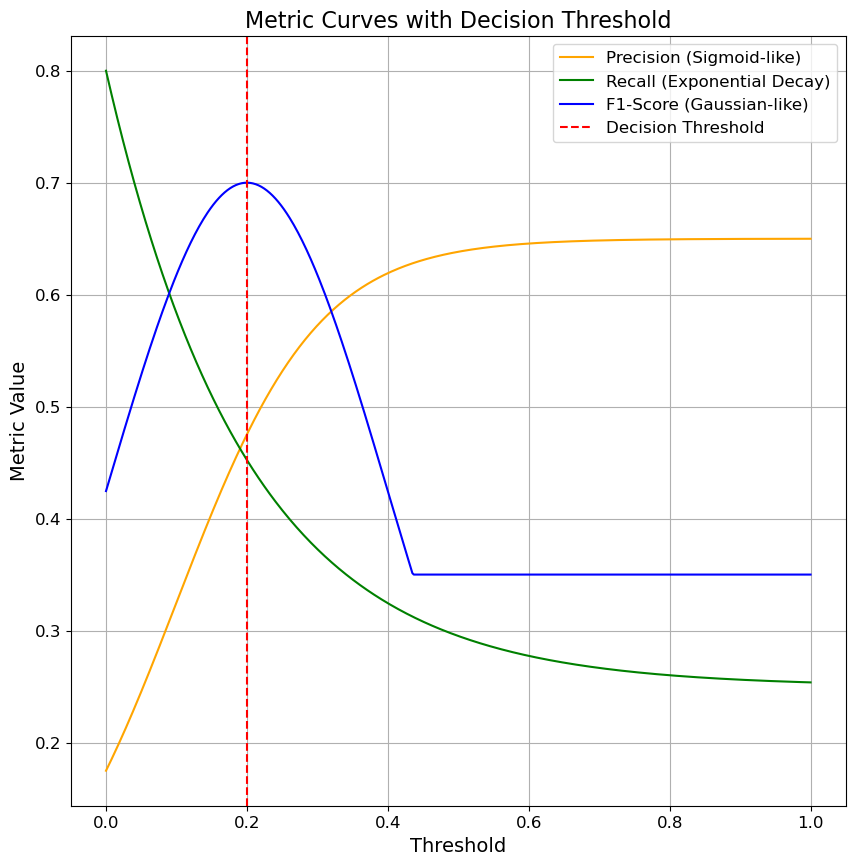

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the threshold range
thresholds = np.linspace(0, 1, 500)

# Max values for the metrics
precision_max = 0.65
recall_max = 0.8
f1_score_max = 0.7

# Min values for the metrics
f1_score_min = 0.35
recall_min = 0.25

# Sigmoid-like curve for Precision
precision = precision_max / (1 + np.exp(-10 * (thresholds - 0.1)))

# Exponential decay for Recall, with a minimum value set to recall_min
recall = (recall_max - recall_min) * np.exp(-5 * thresholds) + recall_min

# Gaussian-like curve for F1-Score
c = 0.2  # Standard deviation for the Gaussian curve
f1_score = f1_score_max * np.exp(-((thresholds - 0.2) ** 2) / (2 * c**2))

# Ensuring the F1-score does not fall below 0.35
f1_score = np.maximum(f1_score, f1_score_min)

# Finding the decision threshold where the F1-Score is maximized
max_f1_index = np.argmax(f1_score)
decision_threshold = thresholds[max_f1_index]

# Plotting the metric curves with the decision threshold
plt.figure(figsize=(10, 10))
plt.plot(thresholds, precision, label="Precision (Sigmoid-like)", color="orange")
plt.plot(thresholds, recall, label="Recall (Exponential Decay)", color="green")
plt.plot(thresholds, f1_score, label="F1-Score (Gaussian-like)", color="blue")

# Adding a vertical line for the decision threshold
plt.axvline(
    x=decision_threshold, color="red", linestyle="--", label="Decision Threshold"
)

# Adding labels and title with increased font size for better readability
plt.title("Metric Curves with Decision Threshold", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)

# Adjusting the legend's font size
plt.legend(fontsize=12)

# Increasing the tick size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)

# Show the plot with the new sizing
plt.show()

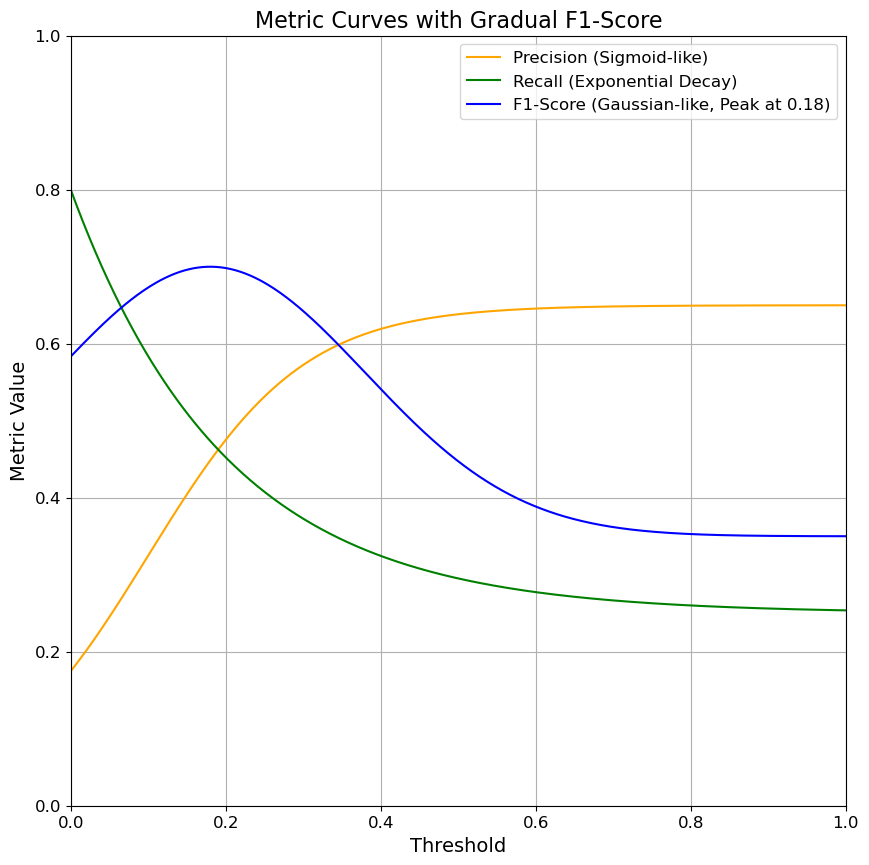

In [18]:
# To make the F1-Score curve gradually decrease without flat-lining, we need to adjust the scaling and offsetting of the Gaussian curve.

peak = 0.18

# Gaussian-like curve for F1-Score
f1_score_gaussian = np.exp(-((thresholds - peak) ** 2) / (2 * c**2))

# Scaling and shifting the Gaussian curve
# The scale factor ensures the peak reaches f1_score_max, and then we offset it to have a minimum value of 0.3
scale_factor = (f1_score_max - f1_score_min) / (
    np.max(f1_score_gaussian) - np.min(f1_score_gaussian)
)
f1_score = scale_factor * (f1_score_gaussian - np.min(f1_score_gaussian)) + f1_score_min

# Plotting the updated F1-Score curve
plt.figure(figsize=(10, 10))
plt.plot(thresholds, precision, label="Precision (Sigmoid-like)", color="orange")
plt.plot(thresholds, recall, label="Recall (Exponential Decay)", color="green")
plt.plot(
    thresholds, f1_score, label="F1-Score (Gaussian-like, Peak at 0.18)", color="blue"
)

# Adding labels and title with increased font size for better readability
plt.title("Metric Curves with Gradual F1-Score", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)

# Adjusting the legend's font size
plt.legend(fontsize=12)

# Increasing the tick size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)

plt.ylim(0, 1)
plt.xlim(0, 1)

# Show the plot with the new sizing
plt.savefig("../../../../area_52/figures/decision_threshold_example.png")